<a href="https://colab.research.google.com/github/PROFOUNDIVE/AIDHellCamp2/blob/dev2/baseline_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6공학관 층 분류하기 - AID 지옥캠프2

- 작성된 환경: Window 11, Pip, Python 3.9, CUDA 11.8, VScode
- Google Colab 등의 클라우드 컴퓨팅 환경에서는 다른 동작을 할 가능성 있음

## 실행 전 사전 준비

### 모듈
- shell에서
``` shell
# Colab 환경은 필요한 모든 모듈이 설치되어 있어 설치할 필요 x
```
``` shell
# 본인 GPU(CUDA)에 맞는 버전을 설치해주세요
# 참고: https://pytorch.org/get-started/locally/
# ex1) Pip, CPU 환경
# pip3 install torch torchvision torchaudio
# ex2) Conda, CUDA 12.4 환경
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
```shell
pip3 install -U scikit-learn
pip3 install -U matplotlib
pip3 install tqdm
```

### 데이터 파일
- 데이터 파일을 root 경로(baseline_code.ipynb가 있는 폴더)에 압축해제 해주세요
- data link: https://www.kaggle.com/datasets/hyunseok21/jiokdata
- colab 환경이라면 다음 [챕터](#colab-환경에서-kaggle파일-다운로드하기---로컬환경이라면-건너뛰기) 확인해주세요
``` shell
📁root
 ├─📁test
 ├─📁train
 │  ├─📁2F_train
 │  ├─📁3F_train
 │  ├─📁4F_train
 │  └─📁5F_train
 └─📜baseline_code.ipynb
```

#### Colab 환경에서 kaggle파일 다운로드하기 - **로컬환경이라면 건너뛰기**

In [1]:
# 실행 시 업로드 버튼 활성화
# kaggle에서 발급받은 api key가 담긴 json 파일 업로드
COLAB = True
try:
  from google.colab import files
  files.upload()
except:
  COLAB = False

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
if COLAB:
  import kagglehub
  import shutil

  # Download latest version
  path = kagglehub.dataset_download("hyunseok21/jiokdata")

  print("Path to dataset files:", path)
  shutil.move(path+'./train', '/content/')
  shutil.move(path+'./test', '/content/')

In [4]:
!pip install efficientnet_pytorch

# Train Data로 학습하기

## 모델 학습 (with train data)

### 모듈 불러오기

In [5]:
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

### CUDA 코어 테스트 & 할당

In [6]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
  print(torch.__version__)
  print(torch.version.cuda)
  x = torch.randn(1).cuda()
  print(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

NVIDIA GeForce RTX 4070 SUPER
2.5.1
12.4
tensor([-2.0100], device='cuda:0')


device(type='cuda', index=0)

### 하이퍼 파라미터 (Hyper Parameter)

In [7]:
params = {
  # For Train
  'epoch': 40,
  'batch_size': 32,

  # CPU worker
  'workers': 8, # 본인 cpu 쓰레드의 절반 정도

  # imgShow
  'num_show_img': 5, # 데이터가 잘 로드 되었는지 확인 하는 셀에서 보여줄 데이터 개수, 학습과 관련 없음

  # For Optimizer
  'learning_rate': 1e-6,
}

### 저장할 학습 완료 모델 파일 이름

In [8]:
pt_file_name = 'model.pt'

### 데이터 라벨링

In [9]:
class_names = {
  "0": "2F",
  "1": "3F",
  "2": "4F",
  "3": "5F",
}

### 데이터 전처리

In [10]:
import os
import random
import numpy as np
import torch

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------------
# 0) 난수 시드 고정 (전체적으로 동일한 결과 재현 가능)
# ------------------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# torch.backends.cudnn.deterministic = True  # 필요시 활성화(학습 속도↓, 완전 재현성↑)


# ------------------------------------------------------------------------
# 1) 학습(train)용 증강 Transform & 검증/테스트용 Transform 정의
# ------------------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2,
                               saturation=0.2, hue=0.1)
    ], p=0.8),  # 원하는 확률로 변환 적용
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# valid/test에서는 증강을 적용하지 않고, 리사이즈 & 정규화만 수행
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------------------------------------------------------
# 2) 전체 ImageFolder 불러오기 (transform은 일단 None)
#    - 전체 이미지 인덱스(list(range(len(full_dataset))))를 먼저 구분
# ------------------------------------------------------------------------
full_dataset = datasets.ImageFolder(
    root='./train',  # ImageFolder 구조의 이미지가 있는 폴더
    transform=None   # 나중에 Subset으로 각각 다른 transform을 줄 예정
)

all_indices = list(range(len(full_dataset)))
print("전체 이미지 개수:", len(full_dataset))

# ------------------------------------------------------------------------
# 3) 8:1:1 (train : valid : test) 분할
#    - 첫 분할: train 80%, 나머지(tmp) 20%
#    - 두 번째 분할: tmp 20% -> valid 10%, test 10%
# ------------------------------------------------------------------------
train_indices, tmp_indices = train_test_split(
    all_indices, test_size=0.2, random_state=SEED, shuffle=True
)
val_indices, test_indices = train_test_split(
    tmp_indices, test_size=0.5, random_state=SEED, shuffle=True
)

print(f"train 개수: {len(train_indices)} | valid 개수: {len(val_indices)} | test 개수: {len(test_indices)}")

# ------------------------------------------------------------------------
# 4) Subset을 통해 train, valid, test에 서로 다른 transform 적용
#    - train -> train_transform (증강 포함)
#    - valid, test -> eval_transform (증강 없음)
#
#    방법:
#      datasets.ImageFolder(...)를 다시 각각 만들되,
#      동일한 root 폴더를 사용하고 transform만 다르게 지정.
#      그리고 Subset에 (원본 ImageFolder, 인덱스) 적용.
# ------------------------------------------------------------------------
train_dataset = Subset(
    datasets.ImageFolder(root='./train', transform=train_transform),
    train_indices
)

val_dataset = Subset(
    datasets.ImageFolder(root='./train', transform=eval_transform),
    val_indices
)

test_dataset = Subset(
    datasets.ImageFolder(root='./train', transform=eval_transform),
    test_indices
)

# ------------------------------------------------------------------------
# 5) DataLoader 정의
# ------------------------------------------------------------------------

dataloaders = {
    'train': DataLoader(train_dataset,
                        batch_size=params['batch_size'],
                        shuffle=True,
                        num_workers=params['workers'],
                        pin_memory=True),
    'valid': DataLoader(val_dataset,
                        batch_size=params['batch_size'],
                        shuffle=False,
                        num_workers=params['workers'],
                        pin_memory=True),
    'test': DataLoader(test_dataset,
                       batch_size=params['batch_size'],
                       shuffle=False,
                       num_workers=params['workers'],
                       pin_memory=True)
}

# ------------------------------------------------------------------------
# 6) 배치 수 계산 및 출력
# ------------------------------------------------------------------------
batch_num = {
    'train': len(dataloaders['train']),
    'valid': len(dataloaders['valid']),
    'test': len(dataloaders['test'])
}

print('batch_size: %d | batch_num(train/valid/test): %d / %d / %d' %
      (params['batch_size'],
       batch_num['train'],
       batch_num['valid'],
       batch_num['test']))

전체 이미지 개수: 7208
train 개수: 5766 | valid 개수: 721 | test 개수: 721
batch_size: 32 | batch_num(train/valid/test): 181 / 23 / 23


### Train 함수
Args:
    model: 학습할 모델.
    criterion: 손실 함수.
    optimizer: 최적화 알고리즘.
    dataloaders: 'train'과 'valid' 단계의 DataLoader.
    num_epochs (int): 학습할 에포크 수.
    checkpoint_path (str): 체크포인트를 저장할 경로.

Returns:
    model: 최적의 가중치를 가진 모델.
    best_idx (int): 최고의 검증 정확도를 달성한 에포크 번호.
    best_acc (float): 최고의 검증 정확도.
    train_loss (list): 각 에포크의 학습 손실.
    train_acc (list): 각 에포크의 학습 정확도.
    valid_loss (list): 각 에포크의 검증 손실.
    valid_acc (list): 각 에포크의 검증 정확도.

In [11]:
import torch
import copy
import time
from tqdm import tqdm

# Function to load the model and optimizer from a checkpoint file
def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path)

    # Load model state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load optimizer state dict (learning_rate 변경하는 경우에는 주석 처리)
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load best accuracy and epoch
    best_acc = checkpoint['best_acc']
    epoch = checkpoint['epoch']

    return model, optimizer, best_acc, epoch

def train_model(model, criterion, optimizer, dataloaders: dict, num_epochs=25, checkpoint_path=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_idx = None  # <-- Needs to be initialized
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    # Load checkpoint if available
    start_epoch = 0
    if checkpoint_path:
        model, optimizer, best_acc, start_epoch = load_checkpoint(model, optimizer, checkpoint_path, device)
        print(f"Resuming training from epoch {start_epoch + 1} with best validation accuracy {best_acc:.2f}%") #

    for epoch in range(start_epoch, num_epochs):  # Start from the last saved epoch
        print()
        print(f'Epoch {epoch + 1}/{num_epochs}:', '-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            count = 1
            pbar_dataloaders = tqdm(dataloaders[phase], desc=phase, ncols=70)
            for inputs, labels in pbar_dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
                count += 1
            pbar_dataloaders.close()

            epoch_loss = running_loss / num_cnt
            epoch_acc = (running_corrects.double() / num_cnt).cpu() * 100

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.2f}') # .1f

            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch + 1
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())  # ★
                print(f'==> best model saved - Epoch {epoch + 1} / {best_acc:.2f}%') # .2f
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc,
                }, pt_file_name)
                print('Checkpoint saved')

    # Final result
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: Epoch {best_idx} / {best_acc:.2f}%')

    model.load_state_dict(best_model_wts)

    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

### 데이터 확인

In [12]:
def imgShow(input, title=None):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = np.clip(input, 0, 1)
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

In [ ]:
# train data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# valid data
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# test data
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])

### 모델을 장치로 할당

In [13]:
# EfficientNet model setup
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)
num_classes = 4
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\ryong\anaconda3\envs\torchdev\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ryong\anaconda3\envs\torchdev\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 손실함수 & 옵티마이저

Adam:
대부분의 경우 기본값으로 사용해도 잘 작동.  
SGD with Momentum:
데이터셋이 크거나, 안정적인 학습이 중요할 때 유리.  
AdamW:
EfficientNet 등 최신 아키텍처와 조합 시 추천.


In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=1e-2)

### 학습 시작

In [ ]:
# Load checkpoint if exists, otherwise train from scratch
checkpoint_path = pt_file_name if os.path.exists(pt_file_name) else None

print(params) # print Hyperparameters

model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(
    model, criterion, optimizer, dataloaders, num_epochs=params['epoch'], checkpoint_path=checkpoint_path
)

{'epoch': 40, 'batch_size': 32, 'workers': 8, 'num_show_img': 5, 'learning_rate': 1e-06}


C:\Users\ryong\AppData\Local\Temp\ipykernel_1540\4270669101.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 22 with best validation accuracy 99.86%

Epoch 22/40: ----------


train: 100%|████████████████████████| 181/181 [01:29<00:00,  2.03it/s]


train Loss: 0.00 Acc: 99.95


valid: 100%|██████████████████████████| 23/23 [00:25<00:00,  1.09s/it]


valid Loss: 0.01 Acc: 99.72

Epoch 23/40: ----------


train: 100%|████████████████████████| 181/181 [01:29<00:00,  2.02it/s]


train Loss: 0.01 Acc: 99.84


valid: 100%|██████████████████████████| 23/23 [00:25<00:00,  1.12s/it]


valid Loss: 0.01 Acc: 99.72

Epoch 24/40: ----------


train: 100%|████████████████████████| 181/181 [01:30<00:00,  1.99it/s]


train Loss: 0.01 Acc: 99.86


valid: 100%|██████████████████████████| 23/23 [00:26<00:00,  1.15s/it]


valid Loss: 0.01 Acc: 99.72

Epoch 25/40: ----------


train: 100%|████████████████████████| 181/181 [01:27<00:00,  2.06it/s]


train Loss: 0.00 Acc: 99.90


valid: 100%|██████████████████████████| 23/23 [00:24<00:00,  1.08s/it]


valid Loss: 0.01 Acc: 99.72

Epoch 26/40: ----------


train: 100%|████████████████████████| 181/181 [01:28<00:00,  2.05it/s]


train Loss: 0.00 Acc: 99.90


valid: 100%|██████████████████████████| 23/23 [00:25<00:00,  1.13s/it]


valid Loss: 0.01 Acc: 99.72

Epoch 27/40: ----------


train: 100%|████████████████████████| 181/181 [01:28<00:00,  2.03it/s]


train Loss: 0.01 Acc: 99.81


valid: 100%|██████████████████████████| 23/23 [00:25<00:00,  1.11s/it]


valid Loss: 0.01 Acc: 99.58

Epoch 28/40: ----------


train: 100%|████████████████████████| 181/181 [01:30<00:00,  2.00it/s]


train Loss: 0.01 Acc: 99.83


valid: 100%|██████████████████████████| 23/23 [00:26<00:00,  1.17s/it]


valid Loss: 0.01 Acc: 99.72

Epoch 29/40: ----------


train:  57%|█████████████▊          | 104/181 [01:02<00:14,  5.23it/s]

## 학습 결과 분석

best model info:
Model extracted from epoch 21
Valid Acc=100 / Valid Loss=0.0


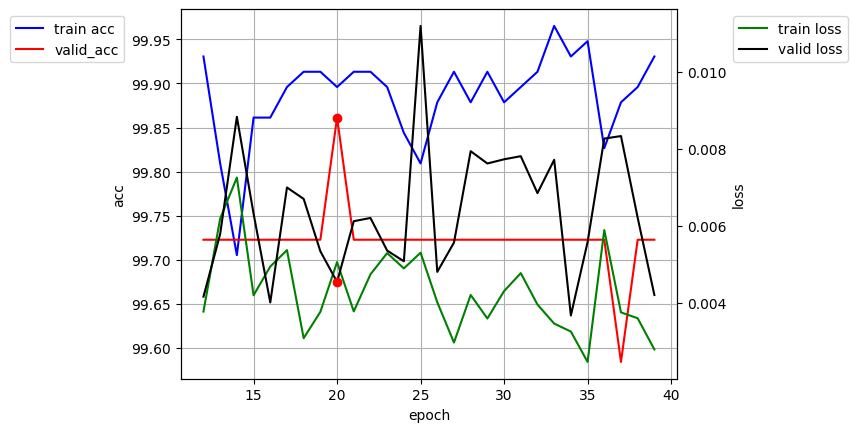

In [13]:
## 결과 그래프 그리기
epoch_corr = 12 # ☆

print('best model info:\nModel extracted from epoch %d\nValid Acc=%2.f / Valid Loss=%.1f'%(best_idx, valid_acc[best_idx-epoch_corr-1], valid_loss[best_idx-epoch_corr-1])) # ☆
fig, ax1 = plt.subplots()

ax1.plot([n for n in range(epoch_corr,len(train_acc)+epoch_corr)], train_acc, 'b-', label='train acc') # ☆
ax1.plot([n for n in range(epoch_corr,len(valid_acc)+epoch_corr)], valid_acc, 'r-', label ='valid_acc') # ☆
plt.plot(best_idx-1, valid_acc[best_idx-epoch_corr-1], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(-0.1, 1.0), loc="upper right")
plt.grid()

ax2 = ax1.twinx()
ax2.plot([n for n in range(epoch_corr,len(train_loss)+epoch_corr)], train_loss, 'g-', label='train loss') # ☆
ax2.plot([n for n in range(epoch_corr,len(valid_loss)+epoch_corr)], valid_loss, 'k-', label='valid loss') # ☆
plt.plot(best_idx-1, valid_loss[best_idx-epoch_corr-1], 'ro') # ☆
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')
plt.legend(bbox_to_anchor=(1.1, 1.0), loc="upper left")


plt.show()

## 모델 TEST

In [15]:
def test_and_visualize_model(model, dataloaders, phase = 'test', num_images=4):
  # phase = 'train', 'valid', 'test'

  was_training = model.training
  model.eval()

  running_loss, running_corrects, num_cnt = 0.0, 0, 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels) # batch의 평균 loss 출력

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      num_cnt += inputs.size(0) # batch size

    test_loss = running_loss / num_cnt
    test_acc = running_corrects.double() / num_cnt
    print('test done : loss/acc : %.2f / %.2f' % (test_loss, test_acc*100))

  # 예시 그림 출력
  # with torch.no_grad():
  #   for i, (inputs, labels) in enumerate(dataloaders[phase]):
  #     inputs = inputs.to(device)
  #     labels = labels.to(device)

  #     outputs = model(inputs)
  #     _, preds = torch.max(outputs, 1)

  #     for j in range(1, num_images+1):
  #       ax = plt.subplot(num_images//2, 2, j)
  #       ax.axis('off')
  #       ax.set_title('%s : %s -> %s' %(
  #         'True' if class_names[str(labels[j].cpu().numpy())] == class_names[str(preds[j].cpu().numpy())] else 'False',
  #         class_names[str(labels[j].cpu().numpy())],
  #         class_names[str(preds[j].cpu().numpy())]
  #       ))
  #       imgShow(inputs.cpu().data[j])

  #     if i == 0: break

  model.train(mode=was_training) # 다시 train모드로 전환

In [16]:
# model.pt Load해서 test하고 싶으면 주석 Toggle 해제
model_dict = torch.load(pt_file_name, map_location=device)

model = efficientnet_b0(pretrained=True)  # pretrained=True로 사전 학습된 가중치 로드
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(model_dict['model_state_dict'])
model = model.to(device)

test_and_visualize_model(model, dataloaders, phase='test')

C:\Users\ryong\AppData\Local\Temp\ipykernel_16528\971017415.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(pt_file_name, map_location=device)


test done : loss/acc : 0.02 / 99.72


# Test 데이터 분류 및 CSV 만들기

In [17]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import sys

In [18]:
data_path = './test'
image_files = sorted(glob.glob(data_path + '/*'))
csv_filename = 'answer.csv'

os_name = sys.platform
path_split = '/'
if os_name.startswith('win'):
  path_split = '\\'

In [19]:
class TestImageDataset(Dataset):
  def __init__(self, files, transform):
    super().__init__()
    self.files = files
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    file = self.files[index]
    try:
        img = Image.open(file).convert('RGB')
    except Exception as e:
        print(f"Error opening image {file}: {e}")
        raise
    img = self.transform(img)

    return img, file.split(path_split)[-1]

In [20]:
test_transform = transforms.Compose([
                        transforms.Resize((224, 224)), # 224x224 사이즈로 변환
                        transforms.ToTensor(), # 텐서화
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                      ])

In [21]:
test_dataset = TestImageDataset(image_files, test_transform)

In [22]:
test_loader = DataLoader(test_dataset,
                         batch_size=params['batch_size'],
                         shuffle=False,
                         )

In [23]:
model_dict = torch.load(pt_file_name, map_location=device)

trained_model = efficientnet_b0(pretrained=True)  # pretrained=True로 사전 학습된 가중치 로드
trained_model.classifier[1] = torch.nn.Linear(trained_model.classifier[1].in_features, num_classes)
trained_model.load_state_dict(model_dict['model_state_dict'])
trained_model = trained_model.to(device)

# CUDA 확인
print(f"CUDA:{next(trained_model.parameters()).is_cuda}")

C:\Users\ryong\AppData\Local\Temp\ipykernel_16528\3888540806.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(pt_file_name, map_location=device)


CUDA:True


In [24]:
def test_and_make_csv(model, dataloader):
  # phase = 'train', 'valid', 'test'

  model.eval()

  answer_csv = 'id,floor\n'

  pbar_dataloaders = tqdm(dataloader,
                          desc='Making Csv',
                          ncols=70)
  with torch.no_grad():
    for inputs, filenames in pbar_dataloaders:
      inputs = inputs.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(len(preds)):
        answer_csv += f'{filenames[j].split(".")[0]},{class_names[str(preds[j].cpu().numpy())]}\n'
  pbar_dataloaders.close()

  with open(csv_filename, 'w') as file:
    file.write(answer_csv)
    print(f'{csv_filename}가 생성되었습니다.')

In [25]:
test_and_make_csv(trained_model, test_loader)

Making Csv: 100%|█████████████████████| 25/25 [00:54<00:00,  2.18s/it]

answer.csv가 생성되었습니다.


In [27]:
# csv 파일 답안 분포 보기
import csv
from collections import Counter

csv_filename = 'answer.csv'

label_counter = Counter()

with open(csv_filename, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)  # 첫 줄 (헤더) 스킵: ['id', 'floor']
    for row in reader:
        # row 예시: ['image001', '2F']
        if len(row) < 2:
            continue  # 비정상 행이 있다면 무시
        label = row[1]  # 두 번째 열이 floor(라벨)
        label_counter[label] += 1

print("=== Test Set Label Distribution ===")
for label, count in label_counter.items():
    print(f"{label} : {count} images")

=== Test Set Label Distribution ===
4F : 200 images
3F : 200 images
2F : 200 images
5F : 200 images


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [01:20<00:00, 2.11MB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


C:\Users\ryong\anaconda3\envs\torchdev\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ryong\anaconda3\envs\torchdev\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features from test data...
Performing K-Means clustering on test data...
Adjusted Rand Index (ARI): 0.3996
Normalized Mutual Information (NMI): 0.5227
Performing t-SNE for visualization...


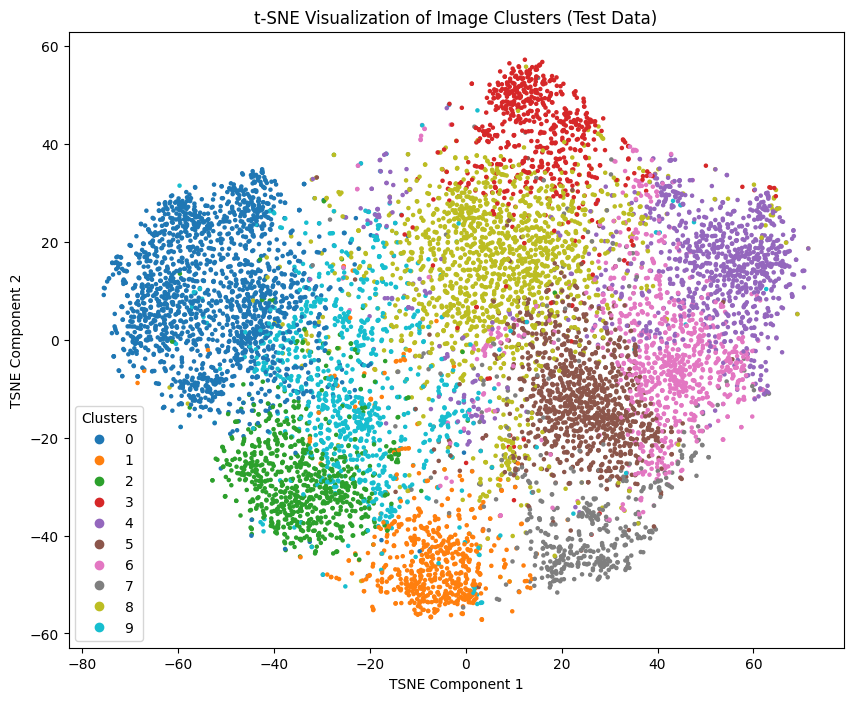

In [30]:
# 이미지 클러스터링(군집도 시각화 - 테스트 데이터만 사용)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Hyperparameters
batch_size = 128
num_clusters = 10  # CIFAR-10의 클래스 수

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet은 224x224 이미지를 기대
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 평균
                         std=[0.229, 0.224, 0.225])   # ImageNet 표준편차
])

# 데이터셋 경로 설정
data_root = './data'  # 실제 데이터가 저장된 상위 디렉토리로 변경하세요

# Load CIFAR-10 테스트 dataset only
test_dataset = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-1])

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # 평가 모드로 설정

def extract_features(data_loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for images, target in data_loader:
            images = images.to(device)
            output = model(images)
            output = output.view(output.size(0), -1)  # Flatten
            features.append(output.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

print("Extracting features from test data...")
test_features, test_labels = extract_features(test_loader, model, device)

# 클러스터링에 사용할 데이터 (테스트 데이터만 사용)
all_features = test_features
all_labels = test_labels

print("Performing K-Means clustering on test data...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(all_features)

# 클러스터링 성능 평가
ari = adjusted_rand_score(all_labels, cluster_assignments)
nmi = normalized_mutual_info_score(all_labels, cluster_assignments)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

print("Performing t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42)
# 전체 테스트 데이터가 클러스터링 되므로 모두 시각화하려면 속도에 유의하세요
# 필요에 따라 일부만 시각화할 수 있습니다
tsne_results = tsne.fit_transform(all_features)  # 전체 데이터 시각화

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cluster_assignments, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Visualization of Image Clusters (Test Data)")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()